# CLIP の実装

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/py-img-gen/python-image-generation/blob/main/notebooks/4-2_clip.ipynb)

## 準備

In [1]:
!pip install -qq py-img-gen[clip]

In [2]:
import warnings

import torch

device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)
dtype = torch.float16
seed = 42

warnings.simplefilter("ignore", FutureWarning)

## CLIP の動作確認

### CLIP モデルの読み込み

In [3]:
from transformers import CLIPModel, CLIPProcessor

model_id = "openai/clip-vit-large-patch14"

# CLIP モデルの読み込み
model = CLIPModel.from_pretrained(model_id)

# モデルを推論モードにする
# このとき dropout を無効化したり、batch normalization の動作を推論用にする
model.eval()

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

### CLIP 用の前処理 pipeline の読み込み

In [4]:
processor = CLIPProcessor.from_pretrained(model_id)
processor

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


CLIPProcessor:
- image_processor: CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

- tokenizer: CLIPTokenizerFast(name_or_path='openai/clip-vit-large-patch14', vocab_size=49408, model_max_length=77, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|startoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	49406: AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, spe

### CLIP のパラメータ情報の表示

In [5]:
import numpy as np

num_params = sum(
    [int(np.prod(p.shape)) for p in model.parameters()]
)
input_resolution = model.config.vision_config.image_size
context_length = processor.tokenizer.model_max_length
num_vocab = model.config.text_config.vocab_size

print(f"Model parameters: {num_params:,}")
print(f"Input resolution: {input_resolution}")
print(f"Context length: {context_length}")
print(f"Vocab size: {num_vocab:,}")

Model parameters: 427,616,513
Input resolution: 224
Context length: 77
Vocab size: 49,408


## CLIPProcessor の動作確認

### サンプル画像のダウンロード

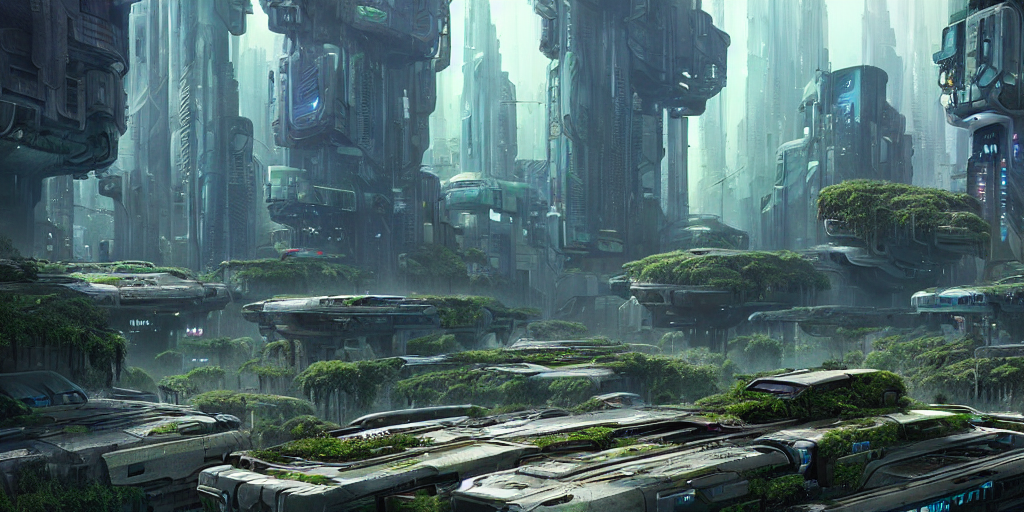

In [6]:
from diffusers.utils import load_image

image = load_image(
    "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/txt2img/000002025.png"
)
image

In [7]:
image.size

(1024, 512)

### CLIPProcessor による画像の前処理

In [8]:
output = processor(images=image, return_tensors="pt")
output

{'pixel_values': tensor([[[[ 1.7260,  0.3391, -0.3908,  ...,  0.9376,  1.0106,  1.1566],
          [ 1.7406,  0.7917, -0.3616,  ...,  0.9230,  0.9668,  1.0690],
          [ 1.7114,  1.4194, -0.0550,  ...,  0.8938,  0.9084,  1.0252],
          ...,
          [-1.4565, -1.3689, -1.5003,  ..., -1.6609, -1.6317, -1.5441],
          [-1.5149, -1.4419, -1.4711,  ..., -1.6463, -1.6025, -1.4565],
          [-1.4857, -1.4711, -1.4273,  ..., -1.6463, -1.6025, -1.6025]],

         [[ 2.0449,  1.1294,  0.4540,  ...,  1.6847,  1.7297,  1.8348],
          [ 2.0299,  1.5046,  0.4841,  ...,  1.6847,  1.7147,  1.8047],
          [ 2.0149,  1.9398,  0.8442,  ...,  1.6697,  1.6997,  1.8047],
          ...,
          [-1.3169, -1.1818, -1.3469,  ..., -1.6170, -1.5570, -1.4820],
          [-1.3169, -1.2118, -1.3019,  ..., -1.6170, -1.5420, -1.3019],
          [-1.2568, -1.1818, -1.2568,  ..., -1.5870, -1.4970, -1.4219]],

         [[ 2.0037,  1.2785,  0.7523,  ...,  1.6909,  1.7051,  1.8046],
          [ 2

In [9]:
output["pixel_values"].size()

torch.Size([1, 3, 224, 224])

### CLIPProcessor によるテキストの前処理

In [10]:
output = processor(text="Hello world", return_tensors="pt")
output

{'input_ids': tensor([[49406,  3306,  1002, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [11]:
processor.batch_decode(output["input_ids"])

['<|startoftext|>hello world <|endoftext|>']

## CLIP による画像とテキストの類似度計算

- 参考: https://github.com/openai/CLIP/blob/main/notebooks/Interacting_with_CLIP.ipynb

### zero-shot 分類用のプロンプトの設定

In [12]:
#
# 使用する skimage の画像とその説明文
#
descriptions_dict = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer",
}

### 画像とテキストのペアの構築

In [13]:
import os

import skimage
from more_itertools import sort_together
from PIL import Image

original_imgs, original_txts = [], []

# skimage から .png か .jpg な画像のパスを習得する
filenames = [
    fname
    for fname in os.listdir(skimage.data_dir)
    if fname.endswith(".png") or fname.endswith(".jpg")
]
for fname in filenames:
    name, _ = os.path.splitext(fname)
    if name not in descriptions_dict:
        continue

    # 画像の読み込み
    image_path = os.path.join(skimage.data_dir, fname)
    original_imgs.append(load_image(image_path))
    # テキストの読み込み
    original_txts.append(descriptions_dict[name])

# 画像とテキストの数があっているか確認
assert len(original_txts) == len(original_imgs)

# テキストの文字列をベースに、テキストと画像のリストをソートする
original_txts, original_imgs = sort_together(
    (original_txts, original_imgs)
)

### 画像とテキストのペアの可視化

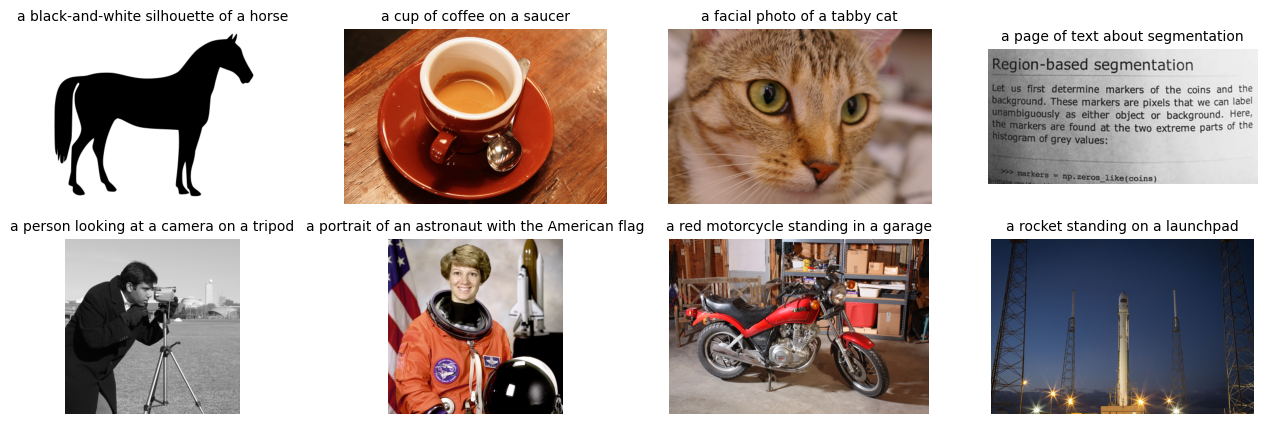

In [14]:
import matplotlib.pyplot as plt

nrows, ncols = 2, 4
fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(16, 5)
)

for i in range(nrows):
    for j in range(ncols):
        axes[i][j].imshow(original_imgs[i * ncols + j])
        axes[i][j].axis("off")
        axes[i][j].set_title(
            original_txts[i * ncols + j], fontsize=10
        )

### 画像とテキストのペアの前処理

In [15]:
inputs = processor(
    text=original_txts,
    images=original_imgs,
    padding="max_length",
    return_tensors="pt",
)
inputs

{'input_ids': tensor([[49406,   320,  1449,   268,   537,   268,  1579, 26149,   539,   320,
          4558, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407],
        [49406,   320,  1937,   539,  2453,   525,   320, 42272, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 

### CLIP による画像とテキストの特徴の取得

In [16]:
import torch

with torch.no_grad():
    img_features = model.get_image_features(
        pixel_values=inputs["pixel_values"],
    )
    txt_features = model.get_text_features(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
    )

### 画像とテキストの類似度計算

In [17]:
img_features = img_features / img_features.norm(
    p=2, dim=-1, keepdim=True
)
txt_features = txt_features / txt_features.norm(
    p=2, dim=-1, keepdim=True
)

similarity = img_features @ txt_features.T

### 画像とテキストの類似度の可視化

Text(0.5, 1.0, 'Cosine similarity between text and image features')

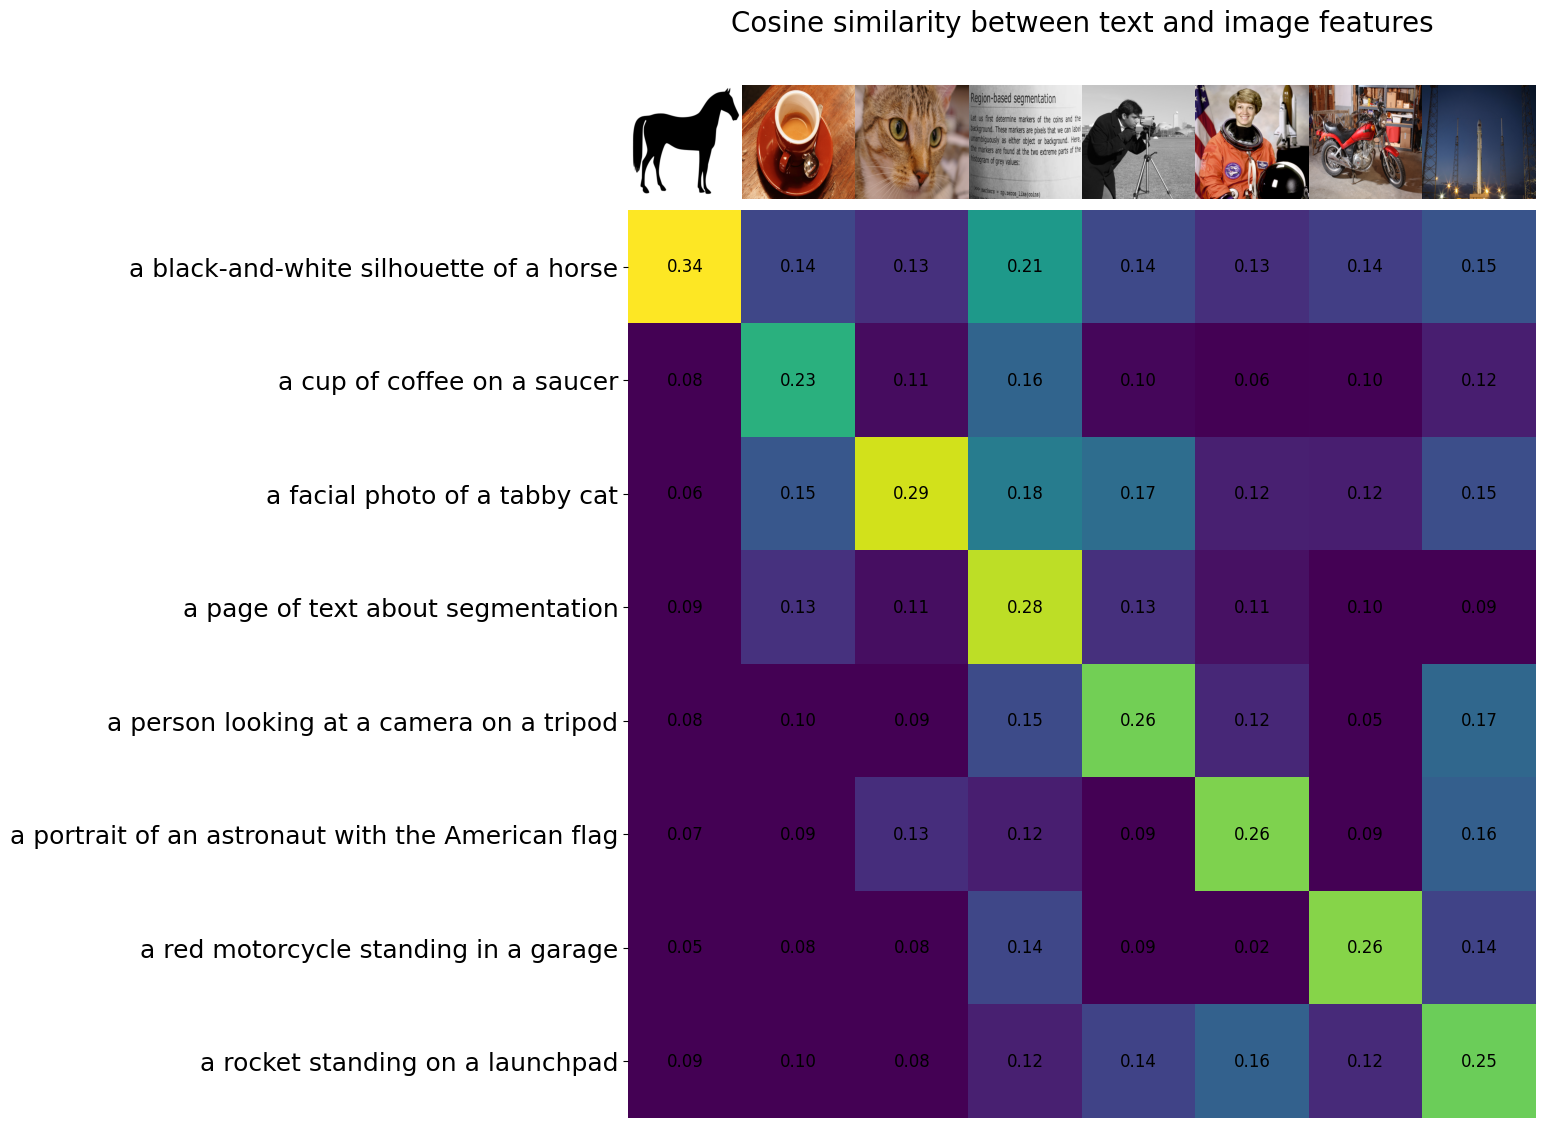

In [18]:
assert len(original_imgs) == len(original_txts)
count = len(original_imgs)

fig, ax = plt.subplots(figsize=(20, 14))
ax.imshow(similarity, vmin=0.1, vmax=0.3)

ax.set_yticks(
    range(len(original_txts)),
    labels=original_txts,
    fontsize=18,
)
ax.set_xticks([])

for i, img in enumerate(original_imgs):
    extent = (i - 0.5, i + 0.5, -1.6, -0.6)
    ax.imshow(img, extent=extent, origin="lower")

for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        s = f"{similarity[y, x]:.2f}"
        a = "center"
        ax.text(x, y, s=s, ha=a, va=a, size=12)

for side in ("left", "top", "right", "bottom"):
    plt.gca().spines[side].set_visible(False)

ax.set_xlim((-0.5, count - 0.5))
ax.set_ylim((count - 0.5, -2))

ax.set_title(
    "Cosine similarity between text and image features",
    size=20,
)

## CLIP による zero-shot 画像分類

### CIFAR100 データセットの読み込み

In [19]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(
    os.path.expanduser("~/.cache"), download=True
)

### プロンプトの準備

In [20]:
text_template = "This is a photo of a {label}"
text_descriptions = [
    text_template.format(label=label)
    for label in cifar100.classes
]

### テキスト特徴の取得

In [21]:
inputs = processor(
    text=text_descriptions,
    padding="max_length",
    return_tensors="pt",
)

with torch.no_grad():
    txt_features = model.get_text_features(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
    )
    txt_features = txt_features / txt_features.norm(
        p=2, dim=-1, keepdim=True
    )

### 類似度を下にした分類結果の取得

In [22]:
txt_probs = 100 * img_features @ txt_features.T
txt_probs = txt_probs.softmax(dim=-1)
top_probs, top_labels = txt_probs.topk(5, dim=-1)

### zero-shot 分類結果の可視化

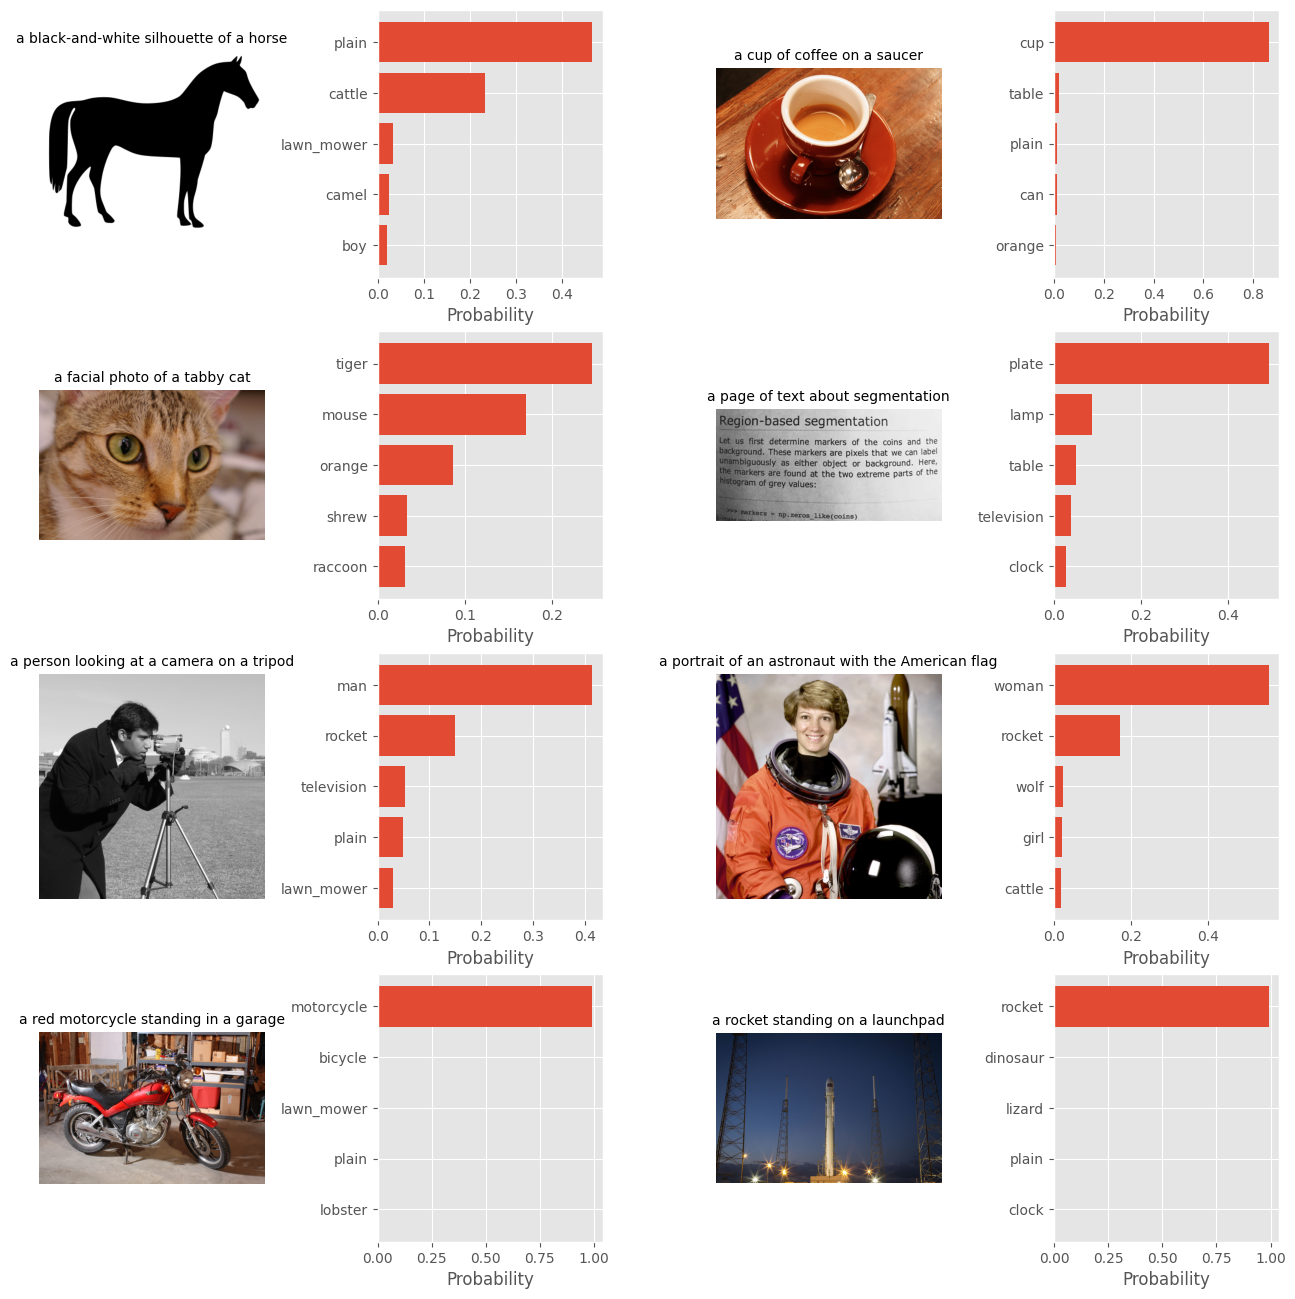

In [23]:
nrows, ncols = 4, 4
fig = plt.figure(figsize=(16, 16))
plt.style.use("ggplot")

y = np.arange(top_probs.shape[-1])

for i, img in enumerate(original_imgs):
    ax1 = fig.add_subplot(nrows, ncols, 2 * i + 1)
    ax1.imshow(img)
    ax1.axis("off")
    ax1.set_title(original_txts[i], fontsize=10)

    ax2 = fig.add_subplot(nrows, ncols, 2 * i + 2)
    ax2.barh(y, top_probs[i])

    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    ax2.set_yticks(
        y, [cifar100.classes[idx] for idx in top_labels[i]]
    )
    ax2.set_xlabel("Probability")

fig.subplots_adjust(wspace=0.5)